In [2]:
import pandas as pd
import os
from driver import Driver
import datetime
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
INSTANCE_FOLDER = "/".join([os.path.dirname(os.getcwd()), "createInstance/instances/"])
INSTANCE_FOLDER_CQ = "/".join([os.path.dirname(os.getcwd()), "createInstance/cq/"])
DATA_FOLDER = "/".join([os.path.dirname(os.getcwd()), "createInstance/data/"])

In [4]:
class Instance:
    def __init__(self) -> None:
        self.df_orders = None
        self.df_depots = None
        self.df_tickets = None
        self.df_employee = None
        self.df_depots_loc = None
        self.df_driver = None
        self.list_driver_nbr = []
        self.instance_size = dict()
        self.dict_driver = {}
        self.depot_loc_id = {}
        #self.clean_depot()
        #self.clean_employee()
        #self.clean_tickets()
        #self.get_driver_from_ticket()
        
    
    def init_order(self)->None:
        self.df_orders = pd.read_excel(f"{DATA_FOLDER}/DORDERSTAB_BETON.xlsx", engine='openpyxl', sheet_name="data")
        self.df_orders.sort_values(by='QUANTITY',inplace=True)
        
    def init_depot(self):
        self.df_depots = pd.read_excel(f"{DATA_FOLDER}/adresses_complete.xlsx")
           
    def init_tickets(self):
        self.df_tickets = pd.read_excel(f"{DATA_FOLDER}/DTICKETHISTAB.xlsx")
    
    def init_employee(self):
        self.df_employee = pd.read_excel(f"{DATA_FOLDER}/EMPLOYETAB.xlsx", engine='openpyxl')
        
    def init_depot_loc(self):
         self.df_depots_loc = pd.read_excel(f"{DATA_FOLDER}/LOCATIONTAB.xlsx", engine='openpyxl')
    
    def clean_depot(self) -> None:
        print("Clean Depot")
        self.df_depots = self.df_depots[self.df_depots['Location_type'] != 'customer']
        self.df_depots.dropna(axis=1, inplace=True)
        self.df_depots['NBR'] = self.df_depots['JOB_DESC'].apply(
            lambda x: x if len(x.split(' ')) == 1 else int(x.split(' ')[1]))
        self.df_depots.set_index('NBR', inplace=True)
        
        self.df_depots_loc['LOC_NBR'] = self.df_depots_loc['LOC_NBR'].apply(lambda x: int(x))
       
        self.df_depots_loc.set_index('LOC_NBR', inplace=True)
        

    def clean_employee(self) -> None:
        print("Clean employee")
        self.df_employee.drop(['COMP_NBR', 'emp_sch_specificite'], axis=1, inplace=True)
        self.df_employee.set_index('EMPL_NBR', inplace=True)
        
    def clean_tickets(self) -> None:
        # Les tickets contiennent les séquences des opérations de distribution
        # Un ticket est la livraison de béton sur un chantier par un livreur

        # Je dois déterminer la séquence de livraison par jour.
        self.df_tickets['DATE'] = self.df_tickets['TICKET_DATE'].apply(lambda x: datetime.date(x.year, x.month, x.day))
        self.df_orders['DATE'] = self.df_orders['SHIPDATE'].apply(lambda x: datetime.date(x.year, x.month, x.day))

        self.df_tickets.dropna(axis=0, inplace=True)
        # # Enlever TRUCK_NBR = ACHATEXT
        # ! self.df_tickets = self.df_tickets[self.df_tickets['TRUCK_NBR'] != 'ACHATEXT']
        # # Enlever livraison dont cap > 12
        self.df_tickets = self.df_tickets[self.df_tickets['QUANTITY'] <= 12]
        # # SHIP_LOC = 099
        self.df_tickets = self.df_tickets[self.df_tickets['SHIP_LOC'] != 99]
        
        self.df_tickets['CUST'] = self.df_tickets['ORDER_ID'].apply(lambda x: self.df_orders[self.df_orders['ORDER_ID']==x]['CUST_NBR'].max())
        self.df_tickets['JOB_DESC'] = self.df_tickets['ORDER_ID'].apply(lambda x: self.df_orders[self.df_orders['ORDER_ID']==x]['JOB_DESC'].max())
                              

        # ! self.df_tickets = self.df_tickets[self.df_tickets['DRIVER_NBR'] != 1]
        # ! self.df_tickets = self.df_tickets[self.df_tickets['DRIVER_NBR'] != 999]
        
    def get_driver_from_ticket(self) -> None:
        # Liste des livreurs disponibles dans le fichier Ticket.
        self.df_driver = self.df_tickets.loc[:, ("DTICKETHIS_TICKET_ID", "SHIP_LOC", "ORDER_ID", "DRIVER_NBR",
                                                 "TRUCK_NBR", "SCHED_LOC", "LOAD", "LOADNR", "QUANTITY")]
        # Enlever les ordres où le numero du chauffeur/camion est manquant
        self.df_driver.dropna(axis=0, inplace=True)
        # Enlever TRUCK_NBR = ACHATEXT
        # ! self.df_driver = self.df_driver[self.df_driver['TRUCK_NBR'] != 'ACHATEXT']
        # Enlever livraison dont cap > 12
        self.df_driver = self.df_driver[self.df_driver['QUANTITY'] <= 12]

        df_copy = self.df_driver[['TRUCK_NBR', 'DRIVER_NBR']].copy()
        df_copy.reset_index(inplace=True)
        df_copy.set_index(['TRUCK_NBR', 'DRIVER_NBR'], inplace=True)
        self.list_driver_nbr = list(dict.fromkeys(df_copy.index))
        employee_nbr = self.df_employee.index
        dummy_driver = []
        for (t_nbr, d_nbr) in self.list_driver_nbr:
            if d_nbr not in employee_nbr:
                dummy_driver.append(d_nbr)
            d = Driver()
            d.t_nbr = t_nbr
            d.d_nbr = int(d_nbr)
            _df = self.df_driver[self.df_driver['TRUCK_NBR'] == t_nbr]
            _cap = max(_df['QUANTITY'])
            if _cap <= 8:
                d.capacity = 8
            else:
                d.capacity = 12
            d.factory_nbr = Counter(_df['SHIP_LOC']).most_common(1)[0][0]
            self.dict_driver[d.t_nbr] = d
            
    def get_driver_from_day(self, day):
        # Liste des livreurs disponibles dans le fichier Ticket.
        df_driver = self.df_tickets.loc[:, ("DTICKETHIS_TICKET_ID", "SHIP_LOC", "ORDER_ID", "DRIVER_NBR",
                                                 "TRUCK_NBR", "SCHED_LOC", "LOAD", "LOADNR", "QUANTITY","DATE")]
        # Enlever les ordres où le numero du chauffeur/camion est manquant
        df_driver.dropna(axis=0, inplace=True)
        # Enlever TRUCK_NBR = ACHATEXT
        # ! self.df_driver = self.df_driver[self.df_driver['TRUCK_NBR'] != 'ACHATEXT']
        # Enlever livraison dont cap > 12
        df_driver = df_driver[df_driver['DATE']==day]
        df_driver = df_driver[df_driver['QUANTITY'] <= 12]

        df_copy = df_driver[['TRUCK_NBR', 'DRIVER_NBR']].copy()
        df_copy.reset_index(inplace=True)
        df_copy.set_index(['TRUCK_NBR', 'DRIVER_NBR'], inplace=True)
        list_driver_nbr = list(dict.fromkeys(df_copy.index))
        employee_nbr = self.df_employee.index
        dummy_driver = []
        dict_driver = {}
        for (t_nbr, d_nbr) in list_driver_nbr:
            if d_nbr not in employee_nbr:
                dummy_driver.append(d_nbr)
            d = Driver()
            d.t_nbr = t_nbr
            d.d_nbr = int(d_nbr)
            _df = df_driver[df_driver['TRUCK_NBR'] == t_nbr]
            _cap = max(_df['QUANTITY'])
            if _cap <= 8:
                d.capacity = 8
            else:
                d.capacity = 12
            d.factory_nbr = Counter(_df['SHIP_LOC']).most_common(1)[0][0]
            dict_driver[d.t_nbr] = d
            
        return dict_driver
            
    def show(self):
        print(f" {len(self.df_orders)} ordres")
        print(f" {len(self.df_driver)} chauffeurs")
        print(f" {len(self.df_depots)} depots")

        
    def create_instance(self, jour) -> None:
        day_op = self.df_tickets[self.df_tickets['DATE'] == jour]
        day_op = day_op[
            ["DTICKETHIS_TICKET_ID", "SHIP_LOC", "ORDER_ID", "DRIVER_NBR", "TRUCK_NBR", "SCHED_LOC", "LOAD", "LOADNR",
             "QUANTITY", "BEGIN_LOAD", "FINISH_LOAD", "ARRIVE_PLANT"]]
        day = jour.day
        if day < 10:
            day = f"0{day}"
        print(f"Instance {day}")
        with open(f"{INSTANCE_FOLDER}/{jour.year}{jour.month}{day}.txt", 'w') as file:
            contents = []
            order_count = 0
            dmd_total = 0
            contents.append(f"Depots:   {len(self.df_depots):8}\n")
            orders_of_day = list(dict.fromkeys(day_op['ORDER_ID']))
            all_orders_of_day = list(dict.fromkeys(self.df_orders['ORDER_ID'][self.df_orders['DATE'] == jour]))
            real_orders_of_day = list(set(all_orders_of_day)&set(orders_of_day))
            print(f"{len(real_orders_of_day)} ordres servis")

            # 2 Nombre de clients
            contents.append(f"Clients:   {len(real_orders_of_day):7}\n")

            list_driver = list(dict.fromkeys(day_op['TRUCK_NBR']))
            print(jour)

            contents.append(f"Drivers:  {len(list_driver):8}\n")

            # 4 Liste des depots
            # for i,d in enumerate(list_depot):
            #     contents.append(f"{i} {df_depots.loc[d]['Location ID']} {d} {df_depots_loc.loc[d]['CAPACITY']}\n")  
            for i, dep in enumerate(self.df_depots.index):
                contents.append(
                    f"{i:2} {self.df_depots.loc[dep]['Location ID']} {dep:2} {int(self.df_depots_loc.loc[dep]['CAPACITY']):3} \n")
                self.depot_loc_id[dep] = i
            # 5 Liste des clients de la journée  
            for i, ord in enumerate(real_orders_of_day):
                ordres = self.df_orders[self.df_orders['ORDER_ID'] == ord]
                if len(ordres) == 0:
                    continue

                ordre = ordres.iloc[0]
                string = f"{i:3} {ord} {ordre['CUST_NBR']} {ordre['LOCATION ID']:4} {self.depot_loc_id[ordre['SCHED_LOC']]:2} {ordre['SHIPTIME (min)']:4.0f} {ordres['QUANTITY'].sum():5.1f} {ordres['QUANTITY'].count():2} \n"
                contents.append(string)
                dmd_total = dmd_total + ordres['QUANTITY'].sum()
            # 6 Liste des ordres de la journée  
            for clientID, ord in enumerate(real_orders_of_day):

                ord_seq = day_op[day_op['ORDER_ID'] == ord]
                ordres = self.df_orders[self.df_orders['ORDER_ID'] == ord]
                if len(ordres) == 0:
                    continue
                for j in range(len(ordres)):
                    ordre = ordres.iloc[j]
                    contents.append(
                        f"{order_count:3} {clientID:3} {ordre['QUANTITY']:5.1f} \n")
                    order_count = order_count + 1

            # 7 Ajouter les chauffeurs
            # Lines of drivers: driver id, driver number, driver rank, depot assigned driver max capacity
            driver_cap = set()
            dict_driver = self.get_driver_from_day(jour)

            for i, id in enumerate(list_driver):
                
                if id not in dict_driver.keys():
                    continue
                
                dr = dict_driver[id]
                df_drv = day_op[day_op['TRUCK_NBR'] == dr.t_nbr]
                _data = df_drv[["BEGIN_LOAD", "ARRIVE_PLANT"]]
                _data.sort_values(["BEGIN_LOAD"], inplace=True)
                # print(dr)
                # _data = test[]
                begin, end = _data.iloc[0, 0], _data.iloc[-1, 1]
                factory_nbr = Counter(df_drv['SHIP_LOC']).most_common(1)[0][0]
                contents.append(
                    f"{i:3} {dr.d_nbr:8} {'_'.join(dr.t_nbr.split(' ')):8} {dr.rank:6} {self.depot_loc_id[factory_nbr]:2} {dr.capacity:2.0f}"
                    f" {int((begin.hour * 60 + begin.minute) / 60) * 60:4}\n")
                driver_cap.add(dr.capacity)
               
                
            contents.insert(2, f"Orders:  {order_count:9}  \n")
            contents[-1] = contents[-1].rstrip()
            contents = "".join(contents)
            file.write(contents)
            self.instance_size[f"{jour.year}{jour.month}{day}"] = [len(self.df_depots), len(real_orders_of_day),
                                                                   order_count,
                                                                   len(list_driver), dmd_total, len(driver_cap)]


   

        pd.DataFrame.from_dict(self.instance_size, orient='index').to_csv(f'{INSTANCE_FOLDER}/instance_size.csv',   sep=';')


In [115]:
Instances_with_extern_fleet = set()
Instances_with_intern_fleet = set()

In [154]:
def create_instance_CQ(Object, jour) -> None:
    
        day_op = Object.df_tickets[Object.df_tickets['DATE'] == jour]

        day_op = day_op[
            ["DTICKETHIS_TICKET_ID", "SHIP_LOC", "ORDER_ID", "DRIVER_NBR", "TRUCK_NBR", "SCHED_LOC", "LOAD", "LOADNR",
             "QUANTITY", "BEGIN_LOAD", "FINISH_LOAD", "ARRIVE_PLANT","PROD_NBR","CUST","JOB_DESC"]]
           
        day = jour.day
        if day < 10:
            day = f"0{day}"
        print(f"Instance {day}")
        with open(f"{INSTANCE_FOLDER_CQ}/{jour.year}{jour.month}{day}.txt", 'w') as file:
            contents = []
            
            print(jour, ' ')
            drivers = list(dict.fromkeys(day_op['DRIVER_NBR']))
            dict_driver = {}
            nb_driver = 0
            for driver in drivers:
                
                trucks = list(dict.fromkeys(day_op['TRUCK_NBR'][day_op['DRIVER_NBR']==driver]))
#                 print(driver,' ',trucks)
                
                if len(trucks)==1:
                    d = Driver()
                    d.t_nbr = trucks[0]
                    d.d_nbr = int(driver)
                    _df = day_op[day_op['TRUCK_NBR'] == d.t_nbr]
                    _cap = max(_df['QUANTITY'])
                    if _cap <= 8:
                        d.capacity = 8
                    else:
                        d.capacity = 12
                    d.factory_nbr = Counter(_df['SHIP_LOC']).most_common(1)[0][0]
                    dict_driver[d.t_nbr] = d
#                     print(d)
                else:
                    if int(driver) == 1:
                        for t in trucks:
                            d = Driver()
                            d.t_nbr = t
                            d.d_nbr = int(driver)
                            _df = day_op[day_op['TRUCK_NBR']==t]
                            _cap = max(_df['QUANTITY'])
                            if _cap <= 8:
                                d.capacity = 8
                            else:
                                d.capacity = 12
                            d.factory_nbr = Counter(_df['SHIP_LOC']).most_common(1)[0][0]
                            dict_driver[d.t_nbr] = d
#                             print(d)
                        print("driver1")
                    else:
                        d = Driver()
                        d.t_nbr = '|'.join(trucks)
                        d.d_nbr = int(driver)
                        _df = day_op[day_op['TRUCK_NBR'].isin(trucks)]
                        _cap = max(_df['QUANTITY'])
                        if _cap <= 8:
                            d.capacity = 8
                        else:
                            d.capacity = 12
                        d.factory_nbr = Counter(_df['SHIP_LOC']).most_common(1)[0][0]
                        dict_driver[d.t_nbr] = d
#                     print(d)
                        
                
#             print(dict_driver)
            
            list_driver = set()
            for driver in drivers:
                driver_orders = list(dict.fromkeys(newInstance.df_tickets['ORDER_ID'][newInstance.df_tickets['DRIVER_NBR']==driver]))
                for ord in driver_orders:
                    job = list(dict.fromkeys(newInstance.df_orders['JOB_DESC'][newInstance.df_orders['ORDER_ID']==ord]))
   
                    if 'PICKUP' not in job:
                        list_driver.add(driver)
                        break
                    else:
                        if len(job)>0:
                            list_driver.add(driver)
                            
            list_driver = list(list_driver)
            print(len(drivers),' VS ',len(list_driver))
            
#             dict_driver = Object.get_driver_from_day(jour)
            
            usedLoc = set()
            for i, id in enumerate(dict_driver):

                dr = dict_driver[id]
                df_drv = day_op[day_op['TRUCK_NBR'].isin (dr.t_nbr.split('|'))]
                _data = df_drv[["BEGIN_LOAD", "ARRIVE_PLANT"]].copy()
                _data.sort_values(["BEGIN_LOAD"], inplace=True)
                usedLoc.add(Counter(df_drv['SHIP_LOC']).most_common(1)[0][0])
               
            count = 0

            for dep in usedLoc:    
                if dep not in Object.df_depots.index:
                    continue
                Object.depot_loc_id[dep] = count
                count = count + 1
        
            #  Ajouter les chauffeurs
            # Lines of drivers: driver id, driver number, driver rank, depot assigned driver max capacity
            driver_cap = set()
            dict_driver = dict(sorted(dict_driver.items(), key=lambda x:(x[1].capacity,x[1].factory_nbr)))
            
            contents.append(f"Drivers:  {len(dict_driver):8}\n")
            
            for i, id in enumerate(dict_driver):
                
                
                dr = dict_driver[id]
                df_drv = day_op[day_op['TRUCK_NBR'].isin(dr.t_nbr.split('|'))]
                _data = df_drv[["BEGIN_LOAD", "ARRIVE_PLANT"]].copy()
                _data.sort_values(["BEGIN_LOAD"], inplace=True)
                begin, end = _data.iloc[0, 0], _data.iloc[-1, 1]
                factory_nbr = Counter(df_drv['SHIP_LOC']).most_common(1)[0][0]
                contents.append(
                    f"{i:3} {dr.d_nbr:8} {'_'.join(dr.t_nbr.split(' ')):8} {dr.rank:6} {Object.depot_loc_id[factory_nbr]:2} {dr.capacity:2.0f}"
                    f" {int((begin.hour * 60 + begin.minute) / 60) * 60:4}\n")
                driver_cap.add(dr.capacity)

                if dr.d_nbr == 1 or dr.d_nbr == 999:
                    Instances_with_extern_fleet.add(jour)
            
            if jour not in Instances_with_extern_fleet:
                Instances_with_intern_fleet.add(jour)
            orders_of_day = list(dict.fromkeys(day_op['ORDER_ID']))
            all_orders_of_day = list(dict.fromkeys(Object.df_orders['ORDER_ID'][Object.df_orders['DATE'] == jour]))
            real_orders_of_day = list(set(orders_of_day))
            print(f"{len(orders_of_day)} {len(all_orders_of_day)} {len(real_orders_of_day)}")
            all_cust_of_day = list(dict.fromkeys(day_op['CUST']))
            
            new_orders = list()

            Object.df_orders.sort_values(['QUANTITY'], inplace=True)
            Map_Qt = dict()
            
            for i, cust in enumerate(all_cust_of_day):
                cust_ordres = list(dict.fromkeys(day_op['ORDER_ID'][day_op['CUST'] == cust][day_op['JOB_DESC'] != 'PICKUP']))
                
                _sum = 0
#                 print('cust ',cust,' ',cust_ordres)
                for ord in cust_ordres:
                    products = list(dict.fromkeys(Object.df_orders['PROD_NBR'][Object.df_orders['ORDER_ID'] == ord][Object.df_orders['JOB_DESC'] != 'PICKUP']))
                    if len(products) == 0:
                        continue

                    for prod in products:
                    
                        prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]
                        demand = prod_day_op['QUANTITY'].sum()
                        if demand < 1:
                            continue
#                         print('ord ' ,ord,' ',prod,' ',demand)
                        
                        _sum = _sum + demand
                if _sum < 1:
                    continue
#                     print(Object.df_orders[Object.df_orders['ORDER_ID']== ord]['SHIPTIME (min)'].min())
                Map_Qt[cust] =  _sum
                
            sortedMap = sorted(Map_Qt.items(), key=lambda x:x[1])
            clientCount = 0
            dmd_total = 0.0
            for i, cust in enumerate(sortedMap):
                
                cust_ordres = list(dict.fromkeys(day_op['ORDER_ID'][day_op['CUST'] == cust[0]][day_op['JOB_DESC'] != 'PICKUP']))
#                 print('cust ',cust[0],':',cust[1])
                
                products = list(dict.fromkeys(day_op['PROD_NBR'][day_op['CUST'] == cust[0]][day_op['JOB_DESC'] != 'PICKUP']))
                
                if len(products) == 0 :
                    continue
                
                if not any(item in orders_of_day for item in cust_ordres):
                    continue 
                    
                for ord in cust_ordres:
                    ordres = Object.df_orders[Object.df_orders['ORDER_ID'] == ord]
                    prod_nbrs = list(dict.fromkeys(ordres['PROD_NBR']))
                    ticket_ordres = day_op[day_op['ORDER_ID'] == ord]
                    ticket_ordres = ticket_ordres[ticket_ordres['PROD_NBR'].isin(prod_nbrs)]
                    if ticket_ordres['QUANTITY'].sum() < 1:
                        continue
                    dmd_total = dmd_total + ticket_ordres['QUANTITY'].sum()
                    ordre = ordres.iloc[0]
                    
                    cur_order_count = 0
                    for val in prod_nbrs:
                        
                        if ticket_ordres[ticket_ordres['PROD_NBR'] == val]['QUANTITY'].sum() > 0:
                            cur_order_count = cur_order_count + 1
                    dep = Counter(ticket_ordres['SCHED_LOC']).most_common(1)[0][0]
                    string = f"{clientCount:3} {ord} {cust[0]} {ordre['LOCATION ID']:4} {Object.depot_loc_id[dep]:2} {ordre['SHIPTIME (min)']:4.0f} {ticket_ordres['QUANTITY'].sum():5.1f} {cur_order_count:2} \n"
                    contents.append(string)
                    new_orders.append(ord)
                    clientCount = clientCount + 1
            
            contents.insert(-clientCount, f"Clients:  {clientCount} {dmd_total}\n")
            
            print('Client Demand ',dmd_total)
                    
            # 6 Liste des ordres de la journée  

            order_count = 0    
            sum_order_dmd = 0
            for clientID, ord in enumerate(new_orders):

                ord_seq = day_op[day_op['ORDER_ID'] == ord]
                ordres = Object.df_orders[Object.df_orders['ORDER_ID'] == ord]
                prod_nbrs = list(dict.fromkeys(ordres['PROD_NBR']))
                
                if len(ordres) == 0:
                    continue
                    
                    
                for prod in prod_nbrs:
                    ticket_ordres = day_op[day_op['ORDER_ID'] == ord]
                    
                    ticket_ordres =  ord_seq[ord_seq['PROD_NBR']==prod]
                    if ticket_ordres['QUANTITY'].sum() < 1:
                        continue
                    sum_order_dmd = sum_order_dmd + ticket_ordres['QUANTITY'].sum()
#                     if len(list(dict.fromkeys(ticket_ordres['SCHED_LOC']))) > 1:
#                         print(ord,' ',prod,' ', list(dict.fromkeys(ticket_ordres['SCHED_LOC'])),' ',Counter(ticket_ordres['SCHED_LOC']).most_common(1)[0][0])
#                     contents.append(f"{order_count:3} {clientID:3} {ticket_ordres['QUANTITY'].sum():5.1f} {Counter(ordres['SCHED_LOC']).most_common(1)[0][0]} {Counter(ticket_ordres['SCHED_LOC']).most_common(1)[0][0]}  \n")
                    dep = Counter(ticket_ordres['SCHED_LOC']).most_common(1)[0][0]
                    contents.append(f"{order_count:3} {clientID:3} {ticket_ordres['QUANTITY'].sum():5.1f}  {Object.depot_loc_id[dep]}  \n")
                    
                    order_count = order_count + 1
                    
            contents.insert(-order_count, f"Orders:  {order_count}  \n")
            
            print('order_demand ',sum_order_dmd)
            
            contents.append(f"Plants:   {len(usedLoc)}\n")
           
            list_driver = list(dict.fromkeys(day_op['TRUCK_NBR']))

            # 4 Liste des depots
             
            for i, dep in enumerate(usedLoc):
                contents.append(
                    f"{i:2} {Object.df_depots.loc[dep]['Location ID']} {dep:2} {int(Object.df_depots_loc.loc[dep]['CAPACITY']):3} \n")
#                 Object.depot_loc_id[dep] = i
            
            # 5 Liste des clients de la journée  
            # 2 Nombre de clients
                
#             contents.insert(2, f"Orders:  {order_count:9}  \n")
            contents[-1] = contents[-1].rstrip()
            contents = "".join(contents)
            file.write(contents)
            Object.instance_size[f"{jour.year}{jour.month}{day}"] = [len(usedLoc), clientCount,
                                                                   order_count,
                                                                   len(list_driver), dmd_total, len(driver_cap)]
        pd.DataFrame.from_dict(Object.instance_size, orient='index').to_csv(f'{INSTANCE_FOLDER_CQ}/instance_size.csv',
                                                                            sep=';',decimal='.')

create_instance_CQ(newInstance,datetime.date(2020, 10, 3))

Instance 03
2020-10-03  
driver1
32  VS  32
11 17 11
Client Demand  651.5
order_demand  651.5


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/3120071117.py:155: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


In [117]:
Instances_with_intern_fleet  

set()

In [96]:
 def create_all_instances(Object) -> None:
        print("Create all instances")
        Instances_with_extern_fleet   = set()  
        Instances_with_intern_fleet = set ()
        Object.instance_size = dict()
        Object.instance_size[f"date"]=['depot','client','order','driver','demand','cap']
        ticket_date = list(dict.fromkeys(Object.df_tickets['DATE']))
#         ticket_date = [datetime.date(2020, 10, 10)]
        for jour in ticket_date:
            create_instance_CQ(Object,jour)
#             create_instance_article(Object,jour)            

In [118]:
Instances_with_extern_fleet   = set()  
Instances_with_intern_fleet = set ()
create_all_instances(newInstance)

Create all instances
Instance 01
2020-10-01  
136  VS  136
104 128 104


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3078.0
922007   3510P   [5, 20]   5
924021   2010RCHQ   [50, 20]   50
924946   2520RP   [20, 54]   20
921577   3520RBOR   [57, 50]   57
926008   3014P   [5, 54]   54
order_demand  3078.0
Instance 02
2020-10-02  
133  VS  133
80 98 80


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  2951.5
919610   MTQ5S   [10, 5]   5
922676   3520P   [20, 10]   20
925015   2520P   [58, 5]   58
923504   2514P   [50, 57]   57
925819   3520RPC1   [5, 54]   54
923138   3520RPC1   [58, 10]   58
order_demand  2951.5
Instance 03
2020-10-03  
35  VS  35
11 17 11
Client Demand  651.5
order_demand  651.5
Instance 05
2020-10-05  


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


120  VS  120
85 119 85


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3190.0
924157   3220RVM   [5, 10]   5
924062   REM2B-M   [35, 5]   5
925914   MTQ4   [20, 50]   50
923263   3220RP   [57, 5]   57
925309   REM3SECANT   [5, 54]   5
order_demand  3190.0
Instance 06
2020-10-06  
141  VS  141
117 146 117


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3749.5
924024   2010RCHQ   [20, 50]   20
922667   3020RP   [20, 54]   20
922667   3020P   [54, 20]   20
926598   4514P   [20, 54]   20
925729   REM3A-M   [54, 20]   54
order_demand  3749.5
Instance 07
2020-10-07  
128  VS  128
66 108 66


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  2512.5
926826   3514RP   [20, 54, 10]   20
927418   3010P2   [5, 20]   5
926770   2520RP   [5, 20]   5
925751   2520RP   [10, 58]   58
921986   3520P   [54, 20]   54
order_demand  2512.5
Instance 08
2020-10-08  
143  VS  143
101 126 101


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  4302.5
926203   MTQ4   [20, 57]   20
922752   MTQ15   [54, 20]   54
920233   3520RPC1   [10, 54]   10
920233   3220RVM   [10, 54]   10
925518   3020P   [57, 54, 20]   57
924826   3520RC1   [57, 35]   57
order_demand  4302.5
Instance 09
2020-10-09  
133  VS  133
104 143 104


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3229.0
923329   2520P   [20, 54]   20
924839   3520RC1   [35, 57, 54]   35
917240   3520RPC1   [20, 54]   20
922668   3020RP   [20, 54]   20
920235   3220RVM   [5, 10]   5
order_demand  3229.0
Instance 10
2020-10-10  
13  VS  13
5 16 5
Client Demand  267.0
order_demand  267.0
Instance 13
2020-10-13  


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


104  VS  104
42 91 42


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  1565.0
925736   2510P   [5, 20, 10]   5
928400   3520RPC1   [5, 10]   5
923208   2520P   [58, 5]   58
order_demand  1565.0
Instance 14
2020-10-14  
142  VS  142
113 140 113


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3471.0
928526   2020RP   [58, 5]   58
926353   2520P   [50, 57]   50
927652   REM3SECANT   [20, 5]   5
922702   3020P   [20, 54]   20
924410   3020P   [10, 54]   10
order_demand  3471.0
Instance 15
2020-10-15  
142  VS  142
92 137 92


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  4181.0
928261   3520RPC1   [20, 54]   20
927283   MTQ4   [50, 57]   50
925903   2520RP   [20, 54]   20
928417   2520RP   [57, 35]   57
927423   3220RVM   [5, 54]   54
925340   REM3SECANT   [20, 5]   20
927653   REM3SECANT   [54, 20, 5]   54
926562   3020P   [58, 5]   58
order_demand  4181.0
Instance 16
2020-10-16  
120  VS  120
74 132 74


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  2060.0
order_demand  2060.0
Instance 17
2020-10-17  
30  VS  30
12 14 12


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  819.0
order_demand  819.0
Instance 19
2020-10-19  
137  VS  137
94 147 94


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3009.5
928709   3020P   [35, 57]   57
925959   2010RCHQ   [57, 20]   57
924975   3520RPC1   [5, 10]   5
924240   3520RPC1   [54, 10]   54
order_demand  3009.5
Instance 20
2020-10-20  
136  VS  136
85 162 85


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  2638.0
928119   3520RVM   [57, 20]   57
925407   3220R   [50, 57]   50
928925   3220RVM   [5, 10]   5
920243   3520RPC1   [5, 10]   5
929895   3220RVM   [10, 5]   10
order_demand  2638.0
Instance 21
2020-10-21  
76  VS  76
41 102 41
Client Demand  1164.5
930454   4020P   [20, 54]   54
order_demand  1164.5


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Instance 22
2020-10-22  
151  VS  151
114 157 114


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3428.5
929150   3014RPBR   [35, 57]   35
930081   MTQ5S   [20, 54]   20
922500   2520P   [58, 5]   5
920241   3220RVM   [5, 10]   5
928202   3020RP   [20, 5]   20
order_demand  3428.5
Instance 23
2020-10-23  
145  VS  145
117 160 117


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3837.5
929959   3520R   [57, 35]   57
928082   0120RB   [20, 54]   20
928432   3020P   [5, 10]   5
928108   3520RPC1   [10, 58]   58
order_demand  3837.5
Instance 24
2020-10-24  
39  VS  39
10 12 10
Client Demand  957.5
order_demand  957.5
Instance 26
2020-10-26  


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


117  VS  117
67 107 67


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  1839.5
922775   3020P   [50, 57]   50
924621   3520T5C   [20, 54]   20
926739   3520T5C   [20, 54]   20
order_demand  1839.5
Instance 27
2020-10-27  
158  VS  158
100 139 100


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3592.0
929236   3520RVM   [10, 54]   10
928125   3020P   [5, 10]   10
927662   REM3SECANT   [20, 5]   20
order_demand  3592.0
Instance 28
2020-10-28  
149  VS  149
117 185 117


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3089.5
929025   3214RP   [54, 5]   54
927432   3020P   [10, 5]   10
928977   3214RVM   [35, 57]   57
931269   3014RPBR   [35, 57]   35
927663   REM3SECANT   [5, 20]   5
920249   3220RVM   [5, 10]   10
order_demand  3089.5
Instance 29
2020-10-29  
153  VS  153
128 159 128


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3943.5
928973   2520   [20, 5]   20
930846   3020R   [57, 54]   57
930333   2010RCHQ   [35, 5]   5
925967   2010RCHQ   [57, 20]   20
931058   3020P   [35, 57]   35
929247   2520P   [57, 20]   57
930499   3520RPC1   [20, 54]   20
order_demand  3943.5
Instance 30
2020-10-30  
153  VS  153
99 140 99


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3524.0
928979   3220RVM   [35, 57]   35
930221   3520R   [50, 57]   50
931526   2520P   [57, 35]   35
932324   2514RPBR   [57, 35]   57
928436   3020P   [5, 10]   5
932599   3520RPC1   [10, 5]   10
931252   MTQ5S   [10, 54]   10
order_demand  3524.0
Instance 31
2020-10-31  
15  VS  15
4 19 4
Client Demand  375.0
order_demand  375.0
Instance 02
2020-11-02  


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


133  VS  133
99 131 99


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3078.5
931492   3214P   [35, 57]   35
931334   5014RP   [54, 5]   54
932983   0120RB   [10, 5, 20]   5
930245   2520P   [57, 50]   57
926395   3020T-5C   [20, 54]   20
order_demand  3078.5
Instance 03
2020-11-03  
146  VS  146
94 123 94


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  4042.5
931960   2510RP   [20, 54]   20
929948   2520P   [10, 5]   10
931880   3020RP   [35, 57]   57
order_demand  4042.5
Instance 04
2020-11-04  
153  VS  153
113 143 113


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3953.5
933367   3020RP   [57, 35]   57
933066   2520RP   [57, 50]   57
933587   0120RB   [5, 10]   5
930156   3510RPC1   [20, 54]   20
929463   2010RCHQ   [20, 57]   20
931882   3020P   [57, 35]   57
929949   3520RPC1   [10, 5]   10
930907   2520P   [10, 58]   58
929310   3520RPC1   [10, 54]   10
930799   3020RP   [5, 10]   5
933297   2010RP   [58, 5]   58
order_demand  3953.5
Instance 05
2020-11-05  
148  VS  148
113 152 113


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  4080.0
932840   2520P   [57, 20]   57
930181   3020P   [10, 5]   10
933829   3520R   [57, 20]   57
930537   2010P2X   [10, 58]   58
932887   3520RPC1   [5, 10]   5
933248   MTQ5S   [20, 10]   20
931548   3020RP   [50, 20]   50
931548   3020P   [50, 20]   50
930299   3020RP   [5, 54]   5
order_demand  4080.0
Instance 06
2020-11-06  
143  VS  143
116 169 116


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3350.5
931540   3520RPC1   [57, 20]   57
932841   2520P   [57, 20]   20
931499   3220R   [57, 20]   57
930540   2010P2X   [10, 58]   10
930547   2010P2X   [10, 58]   10
932646   3220RVM   [10, 5]   10
926396   3020P   [20, 54]   20
order_demand  3350.5
Instance 07
2020-11-07  
18  VS  18
6 10 6
Client Demand  333.5
order_demand  333.5


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Instance 09
2020-11-09  
98  VS  98
63 73 63


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  1746.5
924616   3520P   [20, 5]   5
order_demand  1746.5
Instance 10
2020-11-10  
146  VS  146
114 138 114


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3499.5
931741   3220R   [57, 35]   57
933875   2010RCHQ   [20, 57]   57
933373   2514RP   [57, 5]   57
934483   0120RB   [54, 5]   54
933789   2520RP   [57, 35]   35
933530   2520RP   [57, 20]   57
927672   REM3SECANT   [5, 20]   5
order_demand  3499.5
Instance 11
2020-11-11  
144  VS  144
101 145 101


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3437.5
931847   2514P   [5, 54]   5
934463   2514P   [57, 35]   57
930758   3020P   [5, 10]   10
order_demand  3437.5
Instance 12
2020-11-12  
143  VS  143
92 114 92


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3684.5
930755   3014P   [5, 10]   5
935087   3520P   [20, 54]   54
933632   3520RPC1   [20, 54]   54
933714   2514RPBR   [57, 35]   57
935104   2020P   [57, 35]   57
933236   2010P2X   [10, 58]   10
order_demand  3684.5
Instance 13
2020-11-13  
145  VS  145
108 146 108


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3670.5
934198   2514RP   [5, 10]   5
933920   3220RVM   [10, 54]   10
934163   3520RBOR   [10, 5]   10
932652   3220RVM   [5, 10]   5
932421   3020P   [50, 57]   50
order_demand  3670.5
Instance 14
2020-11-14  
19  VS  19
7 13 7
Client Demand  388.0
order_demand  388.0


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Instance 16
2020-11-16  
137  VS  137
89 141 89


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  2939.5
935380   3220R   [35, 57]   35
933556   3014P   [54, 10]   54
927904   2010RCHQ   [54, 10]   54
932653   3220RVM   [57, 20]   57
933243   2010P2X   [10, 58]   58
933669   3220RP   [35, 57]   35
932137   3020T0C   [57, 54]   57
934562   3514RP   [10, 20]   20
order_demand  2939.5
Instance 17
2020-11-17  
142  VS  142
106 131 106


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3288.5
934701   2514RPBR   [57, 35]   57
933542   3520T0C   [54, 20]   54
934392   2520P   [20, 54]   54
933381   3520RP   [57, 50]   57
925367   REM3SECANT   [20, 5]   20
935078   2510RPBR   [58, 10]   58
order_demand  3288.5
Instance 18
2020-11-18  
141  VS  141
99 131 99


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3541.0
933768   3520RPC1   [5, 58]   5
932655   3220RVM   [5, 10]   5
929459   2010RCHQ   [50, 57, 20]   50
932891   3510RPC1   [5, 10]   10
935028   3020T-5C   [10, 5]   10
order_demand  3541.0
Instance 19
2020-11-19  
144  VS  144
109 145 109


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3447.5
936133   3214RPBR   [57, 54]   57
936229   2020P   [35, 57]   35
936788   2520P   [50, 20]   50
936764   3520RVM   [5, 10]   5
934393   2520P   [10, 54]   10
934840   2520P   [20, 57]   20
932702   2010R   [10, 5]   10
935148   0120RB   [10, 5]   10
933252   2010P2X   [10, 58]   10
934093   3010RP   [20, 54]   54
934412   REM2B-M   [35, 5]   35
933513   3014P   [35, 57]   57
order_demand  3447.5
Instance 20
2020-11-20  
144  VS  144
114 163 114


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3401.5
935115   4520P   [20, 54]   20
929457   2010RCHQ   [20, 57]   20
936170   2520RP   [50, 57]   57
933898   4020P   [20, 54]   20
934259   3020P   [10, 5]   10
934880   4514RPD   [20, 54]   20
934880   4514PD   [20, 54]   54
936278   REM2B-M   [20, 54]   20
order_demand  3401.5
Instance 21
2020-11-21  
13  VS  13
11 12 11
Client Demand  226.5
order_demand  226.5
Instance 23
2020-11-23  


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


130  VS  130
69 104 69


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  2595.0
936593   2520P   [35, 57]   35
934990   2520RP   [35, 57]   35
936660   2020RP   [57, 20]   57
925375   REM3SECANT   [20, 54]   20
935843   REM7A5   [54, 20]   54
order_demand  2595.0
Instance 24
2020-11-24  
129  VS  129
79 111 79


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  2685.5
936213   2514P   [57, 54]   57
order_demand  2685.5
Instance 25
2020-11-25  
140  VS  140
81 114 81


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  2425.0
937799   3020P   [35, 57]   35
order_demand  2425.0
Instance 26
2020-11-26  
135  VS  135
84 106 84


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  2971.0
935903   3514RPC1   [57, 54]   57
935500   2520P   [57, 50]   57
936282   3514RP   [35, 57]   57
936554   REM2B-M   [20, 54]   20
order_demand  2971.0
Instance 27
2020-11-27  
140  VS  140
79 122 79


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3129.5
936451   2520RP   [57, 20]   57
935461   3510RPC1   [54, 10]   10
927686   REM3SECANT   [20, 54]   54
936284   3020P   [35, 57]   57
order_demand  3129.5
Instance 28
2020-11-28  
31  VS  31
8 9 8


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  776.0
order_demand  776.0
Instance 30
2020-11-30  
118  VS  118
62 90 62
Client Demand  2327.5
938364   3020P   [35, 57]   35
934980   3505PMOR   [57, 54]   57
934980   3020P   [57, 54]   57
order_demand  2327.5


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/593019316.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


In [119]:
print( len(Instances_with_extern_fleet),' ',list(Instances_with_extern_fleet))

44   [datetime.date(2020, 10, 3), datetime.date(2020, 10, 15), datetime.date(2020, 11, 4), datetime.date(2020, 11, 14), datetime.date(2020, 11, 28), datetime.date(2020, 10, 6), datetime.date(2020, 10, 2), datetime.date(2020, 11, 6), datetime.date(2020, 10, 14), datetime.date(2020, 10, 13), datetime.date(2020, 11, 24), datetime.date(2020, 10, 19), datetime.date(2020, 11, 25), datetime.date(2020, 11, 5), datetime.date(2020, 10, 5), datetime.date(2020, 10, 27), datetime.date(2020, 11, 2), datetime.date(2020, 11, 13), datetime.date(2020, 10, 23), datetime.date(2020, 10, 30), datetime.date(2020, 11, 18), datetime.date(2020, 11, 19), datetime.date(2020, 11, 20), datetime.date(2020, 10, 7), datetime.date(2020, 10, 9), datetime.date(2020, 10, 20), datetime.date(2020, 10, 24), datetime.date(2020, 11, 16), datetime.date(2020, 10, 1), datetime.date(2020, 10, 8), datetime.date(2020, 11, 23), datetime.date(2020, 11, 3), datetime.date(2020, 11, 30), datetime.date(2020, 10, 17), datetime.date(2020, 1

In [120]:
print( len(Instances_with_intern_fleet),' ',list(Instances_with_intern_fleet))

7   [datetime.date(2020, 10, 21), datetime.date(2020, 10, 10), datetime.date(2020, 11, 7), datetime.date(2020, 11, 21), datetime.date(2020, 10, 26), datetime.date(2020, 11, 9), datetime.date(2020, 10, 31)]


In [6]:
newInstance = Instance()

In [7]:
newInstance.init_order()

In [8]:
newInstance.init_depot()

In [9]:
newInstance.init_tickets()

In [10]:
newInstance.init_employee()

In [11]:
newInstance.init_depot_loc()

In [12]:
newInstance.clean_depot()   

Clean Depot


In [13]:
newInstance.clean_employee()

Clean employee


In [14]:
newInstance.clean_tickets()

In [70]:
create_instance(newInstance, datetime.date(2020, 10, 31))

Instance 31
4 ordres servis
2020-10-31


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_93690/1765312482.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_93690/1765312482.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_93690/1765312482.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

NameError: name 'self' is not defined

In [380]:
newInstance.create_all_instances()

Create all instances
Instance 01
103 ordres servis
2020-10-01
Instance 02
77 ordres servis
2020-10-02


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 03
10 ordres servis
2020-10-03
Instance 05
85 ordres servis
2020-10-05
Instance 06
115 ordres servis
2020-10-06


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 07
66 ordres servis
2020-10-07
Instance 08
101 ordres servis
2020-10-08


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 09
104 ordres servis
2020-10-09
Instance 10
5 ordres servis
2020-10-10


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 13
42 ordres servis
2020-10-13
Instance 14
113 ordres servis
2020-10-14


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 15
92 ordres servis
2020-10-15
Instance 16
74 ordres servis
2020-10-16


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 17
6 ordres servis
2020-10-17
Instance 19
94 ordres servis
2020-10-19
Instance 20
85 ordres servis
2020-10-20
Instance 21
40 ordres servis
2020-10-21


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 22
113 ordres servis
2020-10-22
Instance 23
116 ordres servis
2020-10-23


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 24
9 ordres servis
2020-10-24
Instance 26
67 ordres servis
2020-10-26
Instance 27
100 ordres servis
2020-10-27


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 28
116 ordres servis
2020-10-28
Instance 29
127 ordres servis
2020-10-29


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 30
98 ordres servis
2020-10-30
Instance 31
4 ordres servis
2020-10-31


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 02
99 ordres servis
2020-11-02
Instance 03
94 ordres servis
2020-11-03


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 04
113 ordres servis
2020-11-04
Instance 05
113 ordres servis
2020-11-05


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 06
116 ordres servis
2020-11-06
Instance 07
6 ordres servis
2020-11-07


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 09
63 ordres servis
2020-11-09
Instance 10
114 ordres servis
2020-11-10


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 11
101 ordres servis
2020-11-11
Instance 12
92 ordres servis
2020-11-12


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 13
108 ordres servis
2020-11-13
Instance 14
7 ordres servis
2020-11-14


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 16
89 ordres servis
2020-11-16
Instance 17
106 ordres servis
2020-11-17


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 18
99 ordres servis
2020-11-18
Instance 19
109 ordres servis
2020-11-19


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 20
114 ordres servis
2020-11-20
Instance 21
11 ordres servis
2020-11-21


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 23
68 ordres servis
2020-11-23
Instance 24
79 ordres servis
2020-11-24


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 25
81 ordres servis
2020-11-25
Instance 26
84 ordres servis
2020-11-26


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Instance 27
79 ordres servis
2020-11-27
Instance 28
8 ordres servis
2020-11-28
Instance 30
62 ordres servis
2020-11-30


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.sort_values(["BEGIN_LOAD"], inplace=True)
/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_79994/2234718423.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [108]:
instances = pd.read_csv("cq/instance_size.csv",sep=';',header=1)
instances = instances[instances['date'].isin([20201121, 20201010, 20201107, 20201031, 20201114, 20201003, 20201128, 20201017, 20201024, 20201021, 20201013, 20201109, 20201026, 20201016, 20201125, 20201007, 20201123, 20201020, 20201124, 20201116, 20201002, 20201126, 20201019, 20201001, 20201102, 20201028, 20201127, 20201005, 20201009, 20201117, 20201106, 20201120, 20201022, 20201111, 20201119, 20201014, 20201110, 20201030, 20201118, 20201027, 20201112, 20201006, 20201023, 20201029, 20201104, 20201103, 20201105])]
instances.reset_index(inplace=True)

<Axes: >

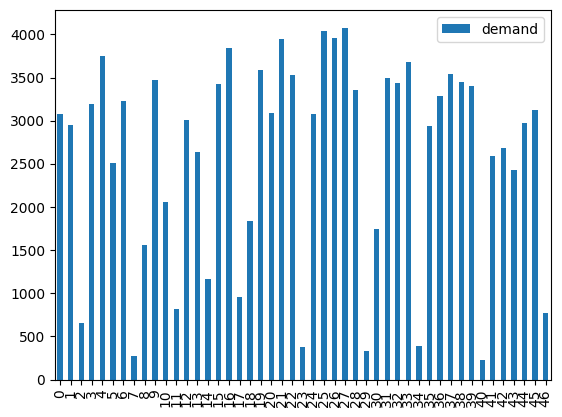

In [109]:
instances.plot(y='demand', kind='bar')

(array([ 5.,  4.,  1.,  2.,  2.,  2.,  3., 11., 11.,  6.]),
 array([ 226.5 ,  611.85,  997.2 , 1382.55, 1767.9 , 2153.25, 2538.6 ,
        2923.95, 3309.3 , 3694.65, 4080.  ]),
 <BarContainer object of 10 artists>)

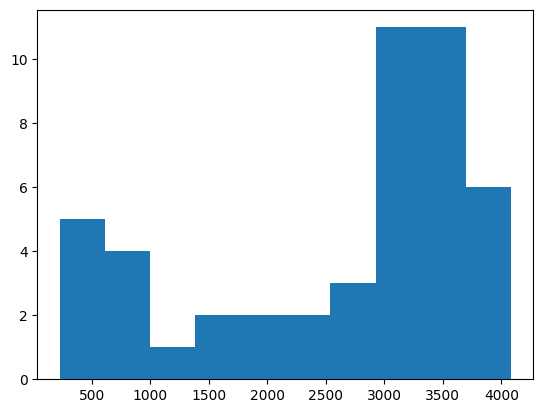

In [103]:
plt.hist(instances['demand'])

<Axes: >

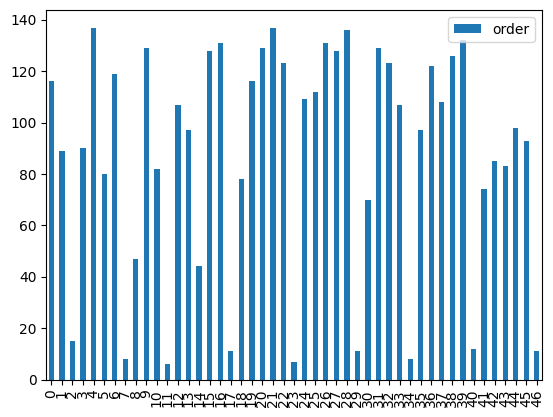

In [110]:
instances.plot(y='order',kind='bar')

(array([ 2.,  4.,  3.,  0.,  0.,  0.,  0.,  2.,  9., 31.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

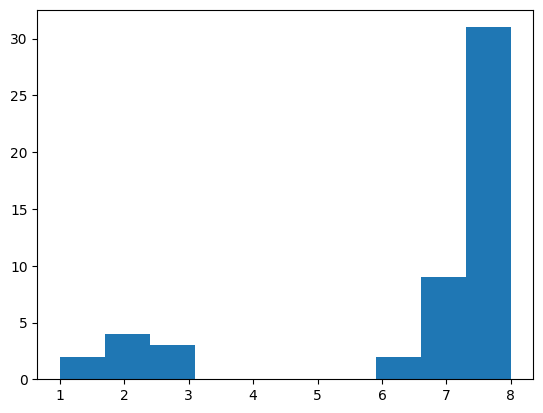

In [83]:
plt.hist(instances['depot'])

/Users/aliwa/miniconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


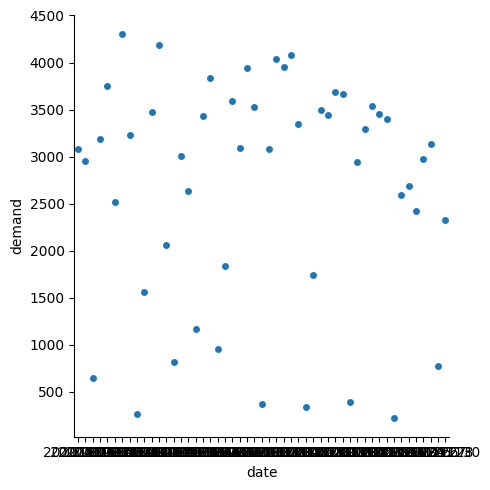

In [81]:
sns.catplot(instances,x='date',y='demand')

In [101]:
def create_instance_article(Object, jour) -> None:
    
        day_op = Object.df_tickets[Object.df_tickets['DATE'] == jour]

        day_op = day_op[
            ["DTICKETHIS_TICKET_ID", "SHIP_LOC", "ORDER_ID", "DRIVER_NBR", "TRUCK_NBR", "SCHED_LOC", "LOAD", "LOADNR",
             "QUANTITY", "BEGIN_LOAD", "FINISH_LOAD", "ARRIVE_PLANT","PROD_NBR","CUST","JOB_DESC"]]
           
        day = jour.day
        if day < 10:
            day = f"0{day}"
        print(f"Instance {day}")
        with open(f"{INSTANCE_FOLDER}/{jour.year}{jour.month}{day}.rmc", 'w') as file:
            contents = []
            
            print(jour, ' ')
            chauffeurs = list(dict.fromkeys(day_op['TRUCK_NBR']))
            list_driver = set()
            for driver in chauffeurs:
                driver_orders = list(dict.fromkeys(newInstance.df_tickets['ORDER_ID'][newInstance.df_tickets['TRUCK_NBR']==driver]))
                for ord in driver_orders:
                    job = list(dict.fromkeys(newInstance.df_orders['JOB_DESC'][newInstance.df_orders['ORDER_ID']==ord]))
   
                    if 'PICKUP' not in job:
                        list_driver.add(driver)
                        break
                    else:
                        if len(job)>0:
                            list_driver.add(driver)
                            
            list_driver = list(list_driver)
            print(len(chauffeurs),' VS ',len(list_driver))
            
            dict_driver = Object.get_driver_from_day(jour)
            
            usedLoc = set()
            for i, id in enumerate(dict_driver):
                if id not in list_driver:
                    continue

                dr = dict_driver[id]
                df_drv = day_op[day_op['TRUCK_NBR'] == dr.t_nbr]
                _data = df_drv[["BEGIN_LOAD", "ARRIVE_PLANT"]].copy()
                _data.sort_values(["BEGIN_LOAD"], inplace=True)
                usedLoc.add(Counter(df_drv['SHIP_LOC']).most_common(1)[0][0])
               
            count = 0

            for dep in usedLoc:    
                if dep not in Object.df_depots.index:
                    continue
                Object.depot_loc_id[dep] = count
                count = count + 1
        
            #  Ajouter les chauffeurs
            # Lines of drivers: driver id, driver number, driver rank, depot assigned driver max capacity
            driver_cap = set()
            dict_driver = Object.get_driver_from_day(jour)
            dict_driver = dict(sorted(dict_driver.items(), key=lambda x:x[1].capacity))
            
            contents.append(f"Drivers:  {len(list_driver):8}\n")
            
            for i, id in enumerate(dict_driver):
                
                if id not in list_driver:
                    continue
                
                dr = dict_driver[id]
                df_drv = day_op[day_op['TRUCK_NBR'] == dr.t_nbr]
                _data = df_drv[["BEGIN_LOAD", "ARRIVE_PLANT"]].copy()
                _data.sort_values(["BEGIN_LOAD"], inplace=True)
                begin, end = _data.iloc[0, 0], _data.iloc[-1, 1]
                factory_nbr = Counter(df_drv['SHIP_LOC']).most_common(1)[0][0]
                contents.append(
                    f"{i:3} {Object.depot_loc_id[factory_nbr]:2} {dr.capacity:2.0f}"
                    f" {int((begin.hour * 60 + begin.minute) / 60) * 60:4}\n")

                driver_cap.add(dr.capacity)
            
            
            orders_of_day = list(dict.fromkeys(day_op['ORDER_ID']))
            all_orders_of_day = list(dict.fromkeys(Object.df_orders['ORDER_ID'][Object.df_orders['DATE'] == jour]))
            real_orders_of_day = list(set(orders_of_day))
            print(f"{len(orders_of_day)} {len(all_orders_of_day)} {len(real_orders_of_day)}")
            all_cust_of_day = list(dict.fromkeys(day_op['CUST']))
            
            new_orders = list()

            Object.df_orders.sort_values(['QUANTITY'], inplace=True)
            Map_Qt = dict()
            
            for i, cust in enumerate(all_cust_of_day):
                cust_ordres = list(dict.fromkeys(day_op['ORDER_ID'][day_op['CUST'] == cust][day_op['JOB_DESC'] != 'PICKUP']))
                _sum = 0
#                 print('cust ',cust,' ',cust_ordres)
                for ord in cust_ordres:
                    products = list(dict.fromkeys(Object.df_orders['PROD_NBR'][Object.df_orders['ORDER_ID'] == ord][Object.df_orders['JOB_DESC'] != 'PICKUP']))
                    if len(products) == 0:
                        continue

                    for prod in products:
                    
                        prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]
                        demand = prod_day_op['QUANTITY'].sum()
                        if demand < 1:
                            continue
                        
                        _sum = _sum + demand
                if _sum < 1:
                    continue
                Map_Qt[cust] = _sum
                
            sortedMap = sorted(Map_Qt.items(), key=lambda x:x[1])
            clientCount = 0
            dmd_total = 0.0
            for i, cust in enumerate(sortedMap):
                
                cust_ordres = list(dict.fromkeys(day_op['ORDER_ID'][day_op['CUST'] == cust[0]][day_op['JOB_DESC'] != 'PICKUP']))
                
                products = list(dict.fromkeys(day_op['PROD_NBR'][day_op['CUST'] == cust[0]][day_op['JOB_DESC'] != 'PICKUP']))
                
                if len(products) == 0 :
                    continue
                
                if not any(item in orders_of_day for item in cust_ordres):
                    continue 
                    
                for ord in cust_ordres:
                    ordres = Object.df_orders[Object.df_orders['ORDER_ID'] == ord]
                    prod_nbrs = list(dict.fromkeys(ordres['PROD_NBR']))
                    ticket_ordres = day_op[day_op['ORDER_ID'] == ord]
                    ticket_ordres = ticket_ordres[ticket_ordres['PROD_NBR'].isin(prod_nbrs)]
                    cur_order_count = 0
                    for val in prod_nbrs:
                        
                        if ticket_ordres[ticket_ordres['PROD_NBR'] == val]['QUANTITY'].sum() > 0:
                            cur_order_count = cur_order_count + 1
                    
                    dmd_total = dmd_total + ticket_ordres['QUANTITY'].sum()
                    ordre = ordres.iloc[0]
                    string = f"{clientCount:3} {ordre['LOCATION ID']:4} {Object.depot_loc_id[ordre['SCHED_LOC']]:2} {ordre['SHIPTIME (min)']:4.0f} {ordres['QUANTITY'].sum():5.1f} {cur_order_count:2} \n"
                    
#                     string = f"{clientCount:3} {ord} {cust[0]} {ordre['LOCATION ID']:4} {Object.depot_loc_id[ordre['SCHED_LOC']]:2} {ordre['SHIPTIME (min)']:4.0f} {ticket_ordres['QUANTITY'].sum():5.1f} {ordres['QUANTITY'].count():2} \n"
                    contents.append(string)
                    new_orders.append(ord)
                    clientCount = clientCount + 1
            
            contents.insert(-clientCount, f"Clients:  {clientCount} {dmd_total}\n")
            
            print('Client Demand ',dmd_total)
                    
            # 6 Liste des ordres de la journée  

            order_count = 0    
            sum_order_dmd = 0
            for clientID, ord in enumerate(new_orders):

                ord_seq = day_op[day_op['ORDER_ID'] == ord]
                ordres = Object.df_orders[Object.df_orders['ORDER_ID'] == ord]
                prod_nbrs = list(dict.fromkeys(ordres['PROD_NBR']))
                
                if len(ordres) == 0:
                    continue
                    
                for prod in prod_nbrs:
                    ticket_ordres = day_op[day_op['ORDER_ID'] == ord]
                    
                    ticket_ordres =  ord_seq[ord_seq['PROD_NBR']==prod]
                    if ticket_ordres['QUANTITY'].sum() < 1:
                        continue
                    sum_order_dmd = sum_order_dmd + ticket_ordres['QUANTITY'].sum()
                   
                    contents.append(f"{order_count:3} {clientID:3} {ticket_ordres['QUANTITY'].sum():5.1f} \n")
                    order_count = order_count + 1
                    
            contents.insert(-order_count, f"Orders:  {order_count}  \n")
            
            print('order_demand ',sum_order_dmd)
            
            contents.append(f"Plants:   {len(usedLoc)}\n")
           
            list_driver = list(dict.fromkeys(day_op['TRUCK_NBR']))

            # 4 Liste des depots
             
            for i, dep in enumerate(usedLoc):
                contents.append(
                    f"{i:2} {Object.df_depots.loc[dep]['Location ID']} {int(Object.df_depots_loc.loc[dep]['CAPACITY']):3} \n")
            
            # 5 Liste des clients de la journée  
            # 2 Nombre de clients
                
#             contents.insert(2, f"Orders:  {order_count:9}  \n")
            contents[-1] = contents[-1].rstrip()
            contents = "".join(contents)
            file.write(contents)
            Object.instance_size[f"{jour.year}{jour.month}{day}"] = [len(usedLoc), clientCount,
                                                                   order_count,
                                                                   len(list_driver), dmd_total, len(driver_cap)]
        pd.DataFrame.from_dict(Object.instance_size, orient='index').to_csv(f'{INSTANCE_FOLDER}/instance_size.csv',
                                                                            sep=';',decimal='.')

create_instance_article(newInstance,datetime.date(2020, 11, 4))

Instance 04
2020-11-04  
153  VS  153
113 143 113


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_68439/2381567899.py:103: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prod_day_op = day_op[day_op['PROD_NBR']==prod][day_op['ORDER_ID']==ord]


Client Demand  3953.5
order_demand  3953.5
